# Capstone Project

## Project Main Details

**Title**: Classification of Ripeness Level from Ecuadorian Bananas\
**Teacher**: Dr. Mohammed Yousefhussien\
**Subject**: INFO-6147-01-Deep_Learning_With_Pytorch

# Assignment Instructions

## 1. Dataset Selection:

- Choose a suitable image dataset for your project. You can consider any of the well-known datasets here Datasets — Torchvision 0.17 documentation (pytorch.org) for simplicity.\
The dataset of Cavendish bananas from Ecuadorian research (Chuquimarca, 2023) will be used. It is conformed from photos of real bananas and synthetic images generated in a virtual scenario using Unreal Engine.

- Ensure that the dataset contains a reasonable number of classes and a sufficient number of images per class.\
The original dataset has 161,280 images divided into real and synthetic images. For the present  project, 14,000 images are selected. They are divided as follows:

  - Real Dataset - 3,495
  - Synthetic Dataset - 10,505

  The real dataset is lower than the synthetic. This is due to the limited number of real images available.

- If the dataset has very large number of images, you can use a subset (e.g., 1000 images per class if number of classes are 10 or less). If the dataset has more than 20 classes, you can use a subset of the classes (e.g., only use 10 classes).\
There dataset has four classes. Each class has its training, validation, and test images. They are divided as follows:
  - Training: 5,000
    - Class A: 1,250
    - Class B: 1,250
    - Class C: 1,250
    - Class D: 1,250
  - Validation: 1,000
    - Class A: 250
    - Class B: 250
    - Class C: 250
    - Class D: 250
  - Test: 1,000
    - Class A: 250
    - Class B: 250
    - Class C: 250
    - Class D: 250

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler
from torch.amp import autocast
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset, Dataset
from torchvision.models import resnet18, ResNet18_Weights, vit_b_16
from torchvision import models

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
#from google.colab import drive
import os
from PIL import Image
from openai import OpenAI

In [6]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Set the random seed ( dot the same for cuda as well)
RANDOM_SEED=42
# Set seed for PyTorch
torch.manual_seed(seed=RANDOM_SEED)
# Setting the seed for CUDA (if using GPUs)
torch.cuda.manual_seed(RANDOM_SEED)

The dataset for the project is 1,4 GB. There are two options to load it:
1. Load from a folder in the cloud.
2. Download and unpack it locally

The following section implements the first option in case it would be needed. Consider that the dataset must be uploaded to Google Drive first.

In [ ]:
# Load the source of the dataset from Google Drive
drive.mount('/content/drive')

# Project path.
wrk_dir = 'path_to_folder'
# Change the current working directory
os.chdir(wrk_dir)

## 2. Data Preprocessing:

- Perform data preprocessing steps such as resizing images, normalizing pixel values, and splitting the dataset into training, validation, and test sets.\
The images are resized to 16*16. Normalization considers a vector of means around 0.5 and std below 0.3.
Three data loaders are created according to the folder structure of the dataset. One for each purpose: training, validation, and test. The structure of folders is the following:

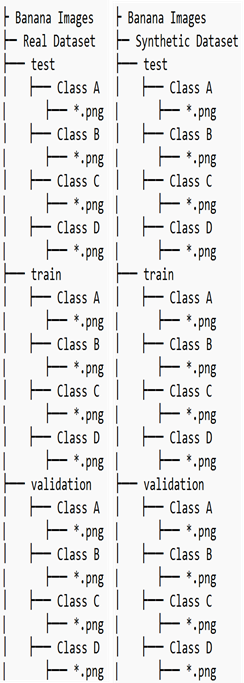

- Apply data augmentation techniques to increase the diversity of the training data.\
The dataset is conformed only by the dataset information of real and synthetic images. No data augmentation technques are implemented.

In [10]:
# Define transformations for the data
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

In [11]:
# Load the data:
# trainset (5000) - valset (1000) - test (1000)

#CPU
batch_size = 8
num_workers = 2
#GPU
# batch_size = 32
# num_workers = 4

# Define variables to load data
test_real_data_path = './Banana Images/Real Dataset/test'
train_real_data_path = './Banana Images/Real Dataset/train'
val_real_data_path = './Banana Images/Real Dataset/validation'

test_synt_data_path = './Banana Images/Synthetic Dataset/test'
train_synt_data_path = './Banana Images/Synthetic Dataset/train'
val_synt_data_path = './Banana Images/Synthetic Dataset/validation'

# Load datasets
real_train_dataset = datasets.ImageFolder(root=train_real_data_path, transform=transform)
real_val_dataset = datasets.ImageFolder(root=val_real_data_path, transform=transform)
real_test_dataset = datasets.ImageFolder(root=test_real_data_path, transform=transform)

synt_train_dataset = datasets.ImageFolder(root=train_synt_data_path, transform=transform)
synt_val_dataset = datasets.ImageFolder(root=val_synt_data_path, transform=transform)
synt_test_dataset = datasets.ImageFolder(root=test_synt_data_path, transform=transform)

**Loading datasets**

In [12]:
# Define the number of samples to load
num_train_samples_rl = 2000
num_val_samples_rl = 500
num_test_samples_rl = 500
num_train_samples_st = 3000
num_val_samples_st = 500
num_test_samples_st = 500

# Create subsets
real_train_subset = Subset(real_train_dataset, range(num_train_samples_rl))
synt_train_subset = Subset(synt_train_dataset, range(num_train_samples_st))
real_val_subset = Subset(real_val_dataset, range(num_val_samples_rl))
synt_val_subset = Subset(synt_val_dataset, range(num_val_samples_st))
real_test_subset = Subset(real_test_dataset, range(num_test_samples_rl))
synt_test_subset = Subset(synt_test_dataset, range(num_test_samples_st))

# Combine subsets
train_dataset = ConcatDataset([real_train_subset, synt_train_subset])
val_dataset = ConcatDataset([real_val_subset, synt_val_subset])
test_dataset = ConcatDataset([real_test_subset, synt_test_subset])

#GPU
trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=True, num_workers=num_workers, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers, pin_memory=True)

## 3. Model Selection and Architecture:

- Select an appropriate deep learning architecture for image classification. You can start with a convolutional neural network (CNN).
- Define the architecture of your model, including the number of layers, activation functions, and any regularization techniques.

### Resnet architecture

In [13]:
# Load the pretrained model
model_rsn = models.resnet18(weights='IMAGENET1K_V1')
# get the number of connections from the fully-connected layer
num_ftrs = model_rsn.fc.in_features
# the dataset has 4 classes, this is the number of outputs
model_rsn.fc = nn.Linear(num_ftrs, 4)
# Move the model to the GPU if available
model =  model_rsn.to(device)
# Define a loss function and optimizer
criterion =  nn.CrossEntropyLoss()
# Adam with optimizer added
optimizer = optim.Adam(model_rsn.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
# help perform the steps of gradient scaling conveniently
scaler = GradScaler()

C:\Users\xavie\AppData\Local\Temp\ipykernel_18660\1967972166.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\ProgramData\anaconda3\envs\DL_PyTorch\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


**Loading model section**

In [15]:
# Load the model state dict with CPU mapping
# weights_only=True added to solve the warning of future behavior of the process
# Google Colab
#model_rsn.load_state_dict(torch.load('/content/prj_resnet_20e_opt3.pth', map_location=torch.device(device), weights_only=True))
# Local environment
model_rsn.load_state_dict(torch.load('prj_resnet_20e_opt3.pth', map_location=torch.device(device), weights_only=True))

# Move the model to the appropriate device
model_rsn.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Model Training:

- Train your deep learning model using the training dataset.
- Monitor training progress, including loss and accuracy, and consider using early stopping to prevent overfitting.

In [39]:
def train_val(model, trainloader, valloader, num_epochs, criterion, scaler):
  # Lists for loss and accuracy to plot later
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  #num_epochs = 20

  for epoch in range(num_epochs):
      running_loss = 0.0
      correct = 0
      total = 0

      print(f'\nEpoch {epoch + 1}/{num_epochs}')
      print('-' * 50)
      print('Training Phase')
      print('-' * 50)

      model.train()
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          # enable automatic mixed precision (some in lower other in higher)
          # improve performance without sacrificing accuracy.
          with autocast(device_type=device):
              outputs = model(inputs)
              loss = criterion(outputs, labels)

          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

          running_loss += loss.item()
          _, preds = torch.max(outputs, 1)
          correct += torch.sum(preds == labels.data)
          total += labels.size(0)

          if (i + 1) % 15 == 0:
              loss = running_loss / total
              accuracy = correct.double() / total
              train_losses.append(loss)
              train_accuracies.append(accuracy)
              print(f'Iteration: {i + 1} Loss: {loss:.4f} Acc: {accuracy:.4f}')

      # Validation at the end of the epoch
      model.eval()
      val_running_loss = 0.0
      val_correct = 0
      val_total = 0

      print('-' * 50)
      print('Validation Phase')
      print('-' * 50)

      with torch.no_grad():
          for i, data in enumerate(valloader, 0):
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs)
              loss = criterion(outputs, labels)

              val_running_loss += loss.item()
              _, preds = torch.max(outputs, 1)
              val_correct += torch.sum(preds == labels.data)
              val_total += labels.size(0)

              if (i + 1) % 3 == 0:
                  val_loss = val_running_loss / val_total
                  val_accuracy = val_correct.double() / val_total
                  val_losses.append(val_loss)
                  val_accuracies.append(val_accuracy)
                  print(f'Iteration: {i + 1} Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')

      #scheduler.step()
      model.train()

  print('Finished Training')
  return model, train_losses, train_accuracies, val_losses, val_accuracies

### Resnet - Training phase

In [39]:
# Lists for loss and accuracy to plot later
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'\nEpoch {epoch + 1}/{num_epochs}')
    print('-' * 50)
    print('Training Phase')
    print('-' * 50)

    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # enable automatic mixed precision (some in lower other in higher)
        # improve performance without sacrificing accuracy.
        with autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

        if (i + 1) % 15 == 0:
            loss = running_loss / total
            accuracy = correct.double() / total
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            print(f'Iteration: {i + 1} Loss: {loss:.4f} Acc: {accuracy:.4f}')

    # Validation at the end of the epoch
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    print('-' * 50)
    print('Validation Phase')
    print('-' * 50)

    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
            val_total += labels.size(0)

            if (i + 1) % 3 == 0:
                val_loss = val_running_loss / val_total
                val_accuracy = val_correct.double() / val_total
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
                print(f'Iteration: {i + 1} Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')

    #scheduler.step()
    model.train()

print('Finished Training')


Epoch 1/20
--------------------------------------------------
Training Phase
--------------------------------------------------
Iteration: 15 Loss: 0.0022 Acc: 0.9729
Iteration: 30 Loss: 0.0022 Acc: 0.9719
Iteration: 45 Loss: 0.0022 Acc: 0.9743
Iteration: 60 Loss: 0.0020 Acc: 0.9760
Iteration: 75 Loss: 0.0019 Acc: 0.9788
Iteration: 90 Loss: 0.0018 Acc: 0.9795
Iteration: 105 Loss: 0.0019 Acc: 0.9795
Iteration: 120 Loss: 0.0018 Acc: 0.9805
Iteration: 135 Loss: 0.0018 Acc: 0.9799
Iteration: 150 Loss: 0.0018 Acc: 0.9800
--------------------------------------------------
Validation Phase
--------------------------------------------------
Iteration: 3 Loss: 0.0028 Acc: 0.9479
Iteration: 6 Loss: 0.0042 Acc: 0.9531
Iteration: 9 Loss: 0.0058 Acc: 0.9479
Iteration: 12 Loss: 0.0050 Acc: 0.9531
Iteration: 15 Loss: 0.0046 Acc: 0.9583
Iteration: 18 Loss: 0.0048 Acc: 0.9566
Iteration: 21 Loss: 0.0043 Acc: 0.9598
Iteration: 24 Loss: 0.0043 Acc: 0.9570
Iteration: 27 Loss: 0.0041 Acc: 0.9583
Iteration:

### Save model

In [ ]:
torch.save(model.state_dict(), 'prj_resnet_20e_opt3.pth')

### Plot

In [18]:
def plot_comparison(train_data, val_data, train_lbl, val_lbl,
                    title, x_label, y_label):
  plt.figure()
  plt.plot(train_data, label=train_lbl)
  plt.plot(val_data, label=val_lbl)
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()

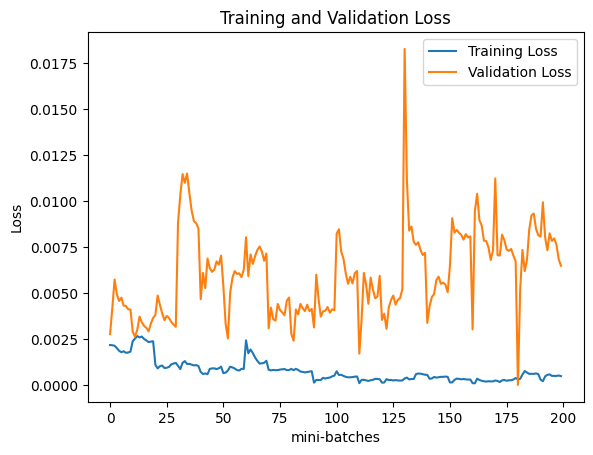

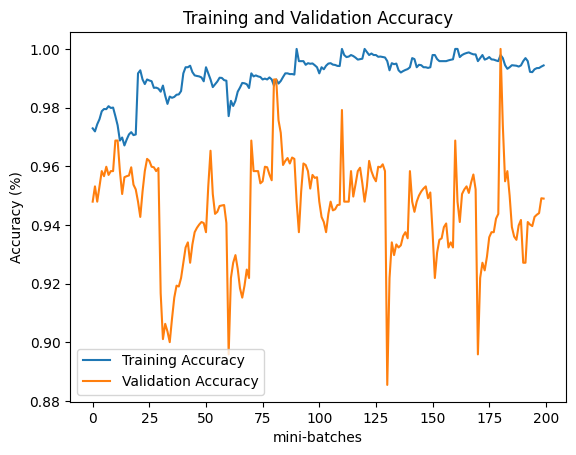

In [43]:
plot_comparison(train_losses, val_losses, 'Training Loss', 'Validation Loss',
                'Training and Validation Loss', 'mini-batches', 'Loss')

# COnvert the tensor into numpy to plot
train_accuracies_plt = [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in train_accuracies]
val_accuracies_plt = [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in val_accuracies]

plot_comparison(train_accuracies_plt, val_accuracies_plt, 'Training Accuracy', 'Validation Accuracy',
                'Training and Validation Accuracy', 'mini-batches', 'Accuracy (%)')

## 5. Hyperparameter Tuning:

- Experiment with different hyperparameters (e.g., learning rate, batch size) to optimize the model's performance.
- Keep a record of the hyperparameters used and their impact on the model.

**Resnet**

* Training set - 5000
* Test set - 1000
* Validation set - 1000
* Epochs - 5 - 10 - 20
* **Adam**
  * lr = 0.01 - 0.001
  * weight_decay=1e-5 (Simply put, weight decay applies a penalty to large parameter values. By constraining the size of the weights, it encourages more stable and interpretable models.)
* autocast - cuda (enable automatic mixed precision (some in lower other in higher), it spped-up the training process)




## 6. Evaluation:

- Evaluate your trained model using the validation dataset to assess its performance.
- Calculate relevant metrics such as accuracy, precision, recall, and F1-score.
- Visualize the model's predictions and misclassifications.

In [27]:
# Function to evaluate model (validation - test)
def evaluate_model(model, dataloader):
  y_true = []
  y_pred = []
  images = []
  total = 0
  correct = 0
  model.eval()
  with torch.no_grad():
      #for i, data in enumerate(dataloader, 0):
      for inputs, labels in dataloader:
          #inputs, labels =  data
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          y_pred.extend(preds.cpu().numpy())
          y_true.extend(labels.cpu().numpy())
          images.extend(inputs.cpu().numpy())
          # Get data to calculate the accuracy in test data
          correct += (preds == labels).sum().item()
          total += labels.size(0)

  # Calculate metrics
  accuracy = correct / total
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  return y_true, y_pred, images, accuracy, precision, recall, f1

In [32]:
# Function to visualize predictions
def visualize_predictions(images, y_true, y_pred, class_names):
    # Convert images from tensor format to numpy format
    images = np.transpose(images, (0, 2, 3, 1))  # Convert from (N, C, H, W) to (N, H, W, C)

    # Plot the first 10 images with their predictions and true labels
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    fig.suptitle('Predictions and Misclassifications')

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i]
            true_label = class_names[y_true[i]]
            pred_label = class_names[y_pred[i]]
            ax.imshow(img)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=('green' if true_label == pred_label else 'red'))
            ax.axis('off')

    plt.show()

### Resnet - Validation phase

In [29]:
# 6 min - 7 sg
y_true_val_rsn, y_pred_val_rsn, imgs_val_rsn, accuracy_val_rsn, precision_val_rsn, recall_val_rsn, f1_val_rsn = evaluate_model(model_rsn, valloader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
print("Metrics for Resnet in validation set:")
print(f"Accuracy: {accuracy_val_rsn * 100:.2f}%")
print(f"Precision: {precision_val_rsn * 100:.2f}%")
print(f"Recall: {recall_val_rsn * 100:.2f}%")
print(f"F1-score: {f1_val_rsn * 100:.2f}%")

Metrics for Resnet in validation set:
Accuracy: 94.30%
Precision: 95.22%
Recall: 94.30%
F1-score: 94.71%


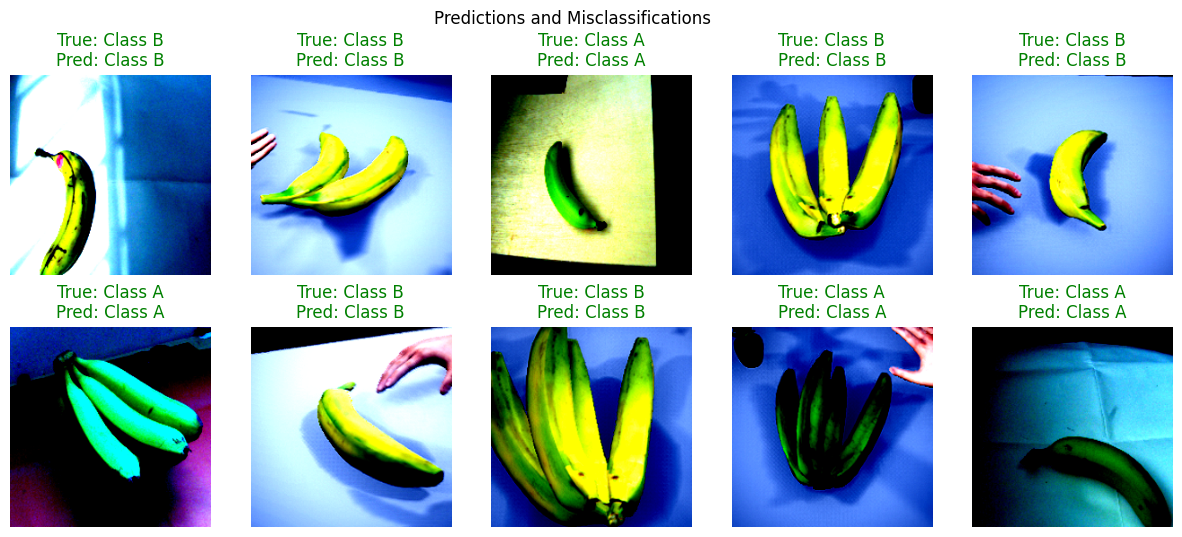

In [33]:
class_names = ['Class A', 'Class B', 'Class C', 'Class D']
visualize_predictions(imgs_val_rsn, y_true_val_rsn, y_pred_val_rsn, class_names)

## 7. Final Model Testing:

- Test your final model on the held-out test dataset to assess its generalization to unseen data.

### Resnet - Test phase

In [34]:
y_true_tst_rsn, y_pred_tst_rsn, imgs_tst_rsn, accuracy_tst_rsn, precision_tst_rsn, recall_tst_rsn, f1_tst_rsn = evaluate_model(model_rsn, testloader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
print("Metrics for Resnet in test set:")
print(f"Accuracy: {accuracy_tst_rsn * 100:.2f}%")
print(f"Precision: {precision_tst_rsn * 100:.2f}%")
print(f"Recall: {recall_tst_rsn * 100:.2f}%")
print(f"F1-score: {f1_tst_rsn * 100:.2f}%")

Metrics for Resnet in test set:
Accuracy: 95.40%
Precision: 96.40%
Recall: 95.40%
F1-score: 95.86%


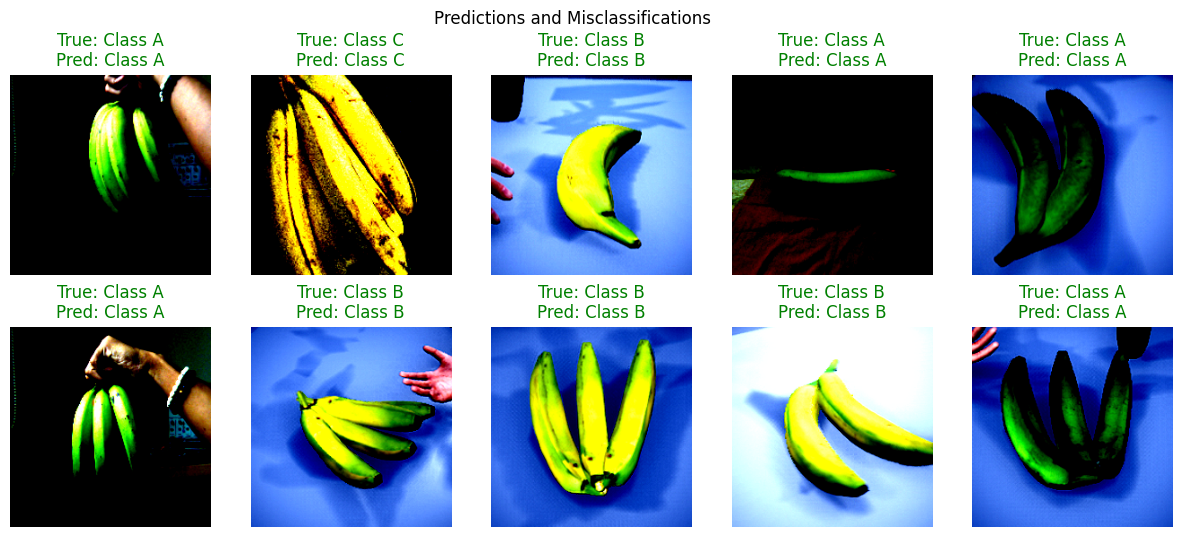

In [36]:
visualize_predictions(imgs_tst_rsn, y_true_tst_rsn, y_pred_tst_rsn, class_names)

## 8. Extra steps

### Asking information to ChatGpt about the prediction

**Installing OpenAI library**

In [1]:
#!pip install -q openai
#!conda install conda-forge::openai

**Asking about the result**

In [40]:
from openai import OpenAI

def ask_gpt():
    message = input("User : ")
    if message:
        with open('api-key.txt') as f:
            text = f.readlines()
        api_key = text[0]
        client = OpenAI(api_key = api_key)
        
        response = client.responses.create(
          model="gpt-4o-mini",
          input=message
        )
        
        print(response.output_text)

**Function to perform a prediction from a single image**

In [42]:
def single_prediction_image(model, dataloader):
  # Create an iterator from the testloader
  dataiter = iter(dataloader)

  # Retrieve the first batch of images
  images = next(dataiter)

  # Extract a single image 
  single_image = images[0]

  # Move the image to the GPU if available
  single_image = single_image.to(device)

  # Perform the prediction
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      single_image = single_image.unsqueeze(0)  # Add batch dimension
      output = model(single_image)
      _, predicted = torch.max(output, 1)

  return predicted.item()

**Class for loading the single image**

In [43]:
# Define a custom dataset
class SingleImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return 1  # Only one image

    def __getitem__(self, idx):
        image = Image.open(self.image_path)
        if self.transform:
            image = self.transform(image)
        return image

**Code to perform predict the image and ask ChatGPT about the result**

In [44]:
class_names = ['Class D', 'Class C', 'Class B', 'Class A']

# Loading new image
image_path = './photo/test1-org.jpg'
#image_path = './photo/test2-org.jpg'
# Create the dataset and dataloader
dataset = SingleImageDataset(image_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# what does it mean that a banana is from a 'Class A'?
result = single_prediction_image(model_rsn, dataloader)
print("Ask something interesting about the result:", class_names[result])
ask_gpt()

Ask something interesting about the result: Class C


User :  Tell me a fun fact about banana class C


Bananas are classified into different classes based on their size and quality, with Class C bananas often being smaller, having more blemishes, or being overripe. A fun fact about Class C bananas is that they are often used for making banana bread, smoothies, or in baking because their sweetness increases as they ripen! They may not be perfect for eating raw, but they are great for delicious recipes.


### Checking areas of interest

**Creating a function to detect attention regions**

In [26]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp, CAM, LayerCAM, GradCAM
from torchcam.utils import overlay_mask

# Function to detect the attention regions in the image
def attention_regions(image_path, model, method = SmoothGradCAMpp):
    # Loading new image
    img = read_image(image_path)
    
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    with method(model) as cam_extractor:
        # Preprocess your data and feed it to the model
        out = model(input_tensor.unsqueeze(0))
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

    # Return the image with the regions
    return result

**Plotting regions**

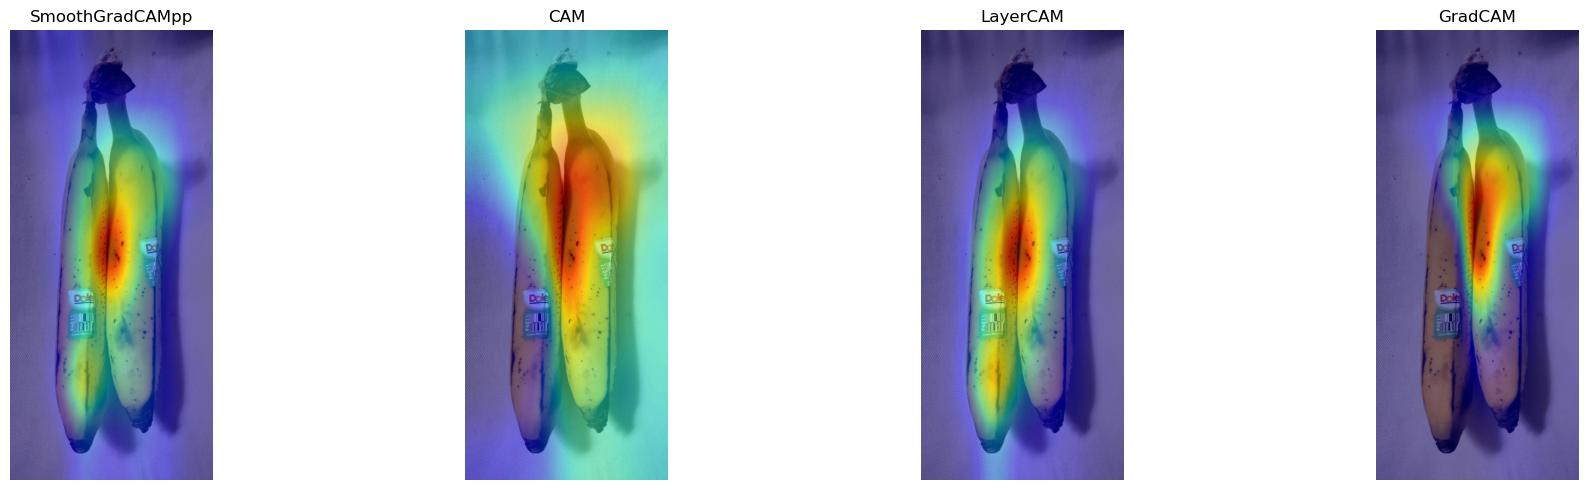

In [51]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18, vgg16
from torchcam.methods import SmoothGradCAMpp, CAM, LayerCAM, GradCAM
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Loading new image
image_path = './photo/test1-org.jpg'
#image_path = './photo/test2-org.jpg'
method_list = [SmoothGradCAMpp, CAM, LayerCAM, GradCAM]

# Create a 1x4 subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, method in enumerate(method_list):
    result = attention_regions(image_path, model_rsn, method)
    axes[i].imshow(result)
    axes[i].axis('off')
    axes[i].set_title(method.__name__)

plt.tight_layout()

## References

- Chuquimarca Jiménez, Luis & Vintimilla, Boris & Velastin, Sergio. (2023). Banana Ripeness Level Classification Using a Simple CNN Model Trained with Real and Synthetic Datasets. 536-543. 10.5220/0011654600003417.
- Openai. (n.d.). Openai/openai-python: The official Python Library for the openai API. GitHub. https://github.com/openai/openai-python
- PyTorch Team. (n.d.). ResNet. PyTorch. https://pytorch.org/hub/pytorch_vision_resnet/ 
- RoX818. (2024, November 25). Fine-Tuning with AdamW: Why Weight Decay Matters. AICompetence. https://aicompetence.org/fine-tuning-with-adamw/
- Torch Contributors. (n.d.-b). Resnet18¶. resnet18 - Torchvision 0.21 documentation. https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18 